# Abnormal detection

Datesets: https://www.kaggle.com/datasets/eliasdabbas/web-server-access-logs?resource=download

(https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/3QBYB5)

Ref: https://www.scutum.jp/information/waf_tech_blog/2021/01/waf-blog-077.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [ ]:
%ls '/content/drive/My Drive/research/anormal_detection/datasets'

access.log  access_small.log  archive.zip  client_hostname.csv  score.csv


In [2]:
PATH = '/content/drive/My Drive/research/anormal_detection/datasets/'
ACCESS_LOG = 'access.log'

In [3]:
from datetime import datetime
import pytz

def parse_str(x):
    # print(f'str:{x}')
    """
    Returns the string delimited by two characters.

    Example:
        `>>> parse_str('[my string]')`
        `'my string'`
    """
    return x[1:-1]

def parse_datetime(x):
    # print(f'time:{x}')
    '''
    Parses datetime with timezone formatted as:
        `[day/month/year:hour:minute:second zone]`

    Example:
        `>>> parse_datetime('13/Nov/2015:11:45:42 +0000')`
        `datetime.datetime(2015, 11, 3, 11, 45, 4, tzinfo=<UTC>)`

    Due to problems parsing the timezone (`%z`) with `datetime.strptime`, the
    timezone will be obtained using the `pytz` library.
    '''
    dt = datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S')
    dt_tz = int(x[-6:-3])*60+int(x[-3:-1])
    return dt.replace(tzinfo=pytz.FixedOffset(dt_tz))

## Load full data

In [4]:
import re
import pandas as pd

# origin
# sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',

# read full data
data = pd.read_csv(
    PATH + ACCESS_LOG,
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\+\d+\])',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': parse_datetime,
                'request': parse_str,
                'status': int,
                'size': int,
                'referer': parse_str,
                'user_agent': parse_str})

Loading took for **9min**

In [ ]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26070       15668        3117           1        7284       12031
Swap:             0           0           0


In [ ]:
data.head()

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...


In [ ]:
data.describe()

,status,size
count,1.036515e+07,1.036515e+07
mean,2.101419e+02,1.243311e+04
std,3.921424e+01,2.812654e+04
min,2.000000e+02,0.000000e+00
25%,2.000000e+02,2.027000e+03
50%,2.000000e+02,4.120000e+03
75%,2.000000e+02,1.155100e+04
max,5.040000e+02,1.249490e+06


## Load chunk data

In [ ]:
import re
import pandas as pd

CHUNK_SIZE = 100000

# read chunk data
data = pd.read_csv(
    PATH + ACCESS_LOG,
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\+\d+\])',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': parse_datetime,
                'request': parse_str,
                'status': int,
                'size': int,
                'referer': parse_str,
                'user_agent': parse_str},
    chunksize=CHUNK_SIZE)

In [ ]:
chunk_train = data.get_chunk(CHUNK_SIZE)

In [ ]:
chunk_train.head(10)

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [ ]:
chunk_train.describe()

,status,size
count,100000.000000,100000.000000
mean,210.929830,16823.097630
std,39.279118,26017.003428
min,200.000000,0.000000
25%,200.000000,2433.750000
50%,200.000000,5807.000000
75%,200.000000,31011.000000
max,504.000000,912896.000000


## Load Test data

In [ ]:
import re
import pandas as pd

TEST_ATTACK_LOG = 'test_attack.log'

# read test attack data
test_data = pd.read_csv(
    PATH + TEST_ATTACK_LOG,
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\+\d+\])',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': parse_datetime,
                'request': parse_str,
                'status': int,
                'size': int,
                'referer': parse_str,
                'user_agent': parse_str})

In [ ]:
test_data

,ip,time,request,status,size,referer,user_agent
0,185.222.202.118,2019-01-22 09:15:46+03:30,GET /public/index.php?s=/index/%5Cthink%5Capp/...,301,178,NaN,python-requests/2.4.3 CPython/2.7.9 Linux/3.16...
1,93.104.209.19,2019-01-22 18:54:36+03:30,GET /mysql/admin/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,93.104.209.19,2019-01-22 18:54:41+03:30,GET /sqlmanager/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
3,93.104.209.19,2019-01-22 18:54:47+03:30,GET /sql/phpMyAdmin2/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,149.12.217.220,2019-01-26 13:25:41+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
5,206.248.167.234,2019-01-26 00:57:39+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
6,5.101.40.234,2019-01-23 06:53:01+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
7,5.101.40.234,2019-01-23 06:53:02+03:30,GET /image/{{basketItem.id}}?type=productModel...,200,5,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
8,5.101.40.234,2019-01-23 06:53:18+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
9,108.61.86.94,2019-01-24 13:08:01+03:30,GET /login.cgi?cli=aa%20aa%27;wget%20http://10...,400,166,NaN,Solstice/2.0


## Load Test data2

In [5]:
import re
import pandas as pd

TEST_ATTACK_LOG = 'test_attack_2.log'

# read test attack data
test_data = pd.read_csv(
    PATH + TEST_ATTACK_LOG,
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\+\d+\])',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': parse_datetime,
                'request': parse_str,
                'status': int,
                'size': int,
                'referer': parse_str,
                'user_agent': parse_str})

In [ ]:
test_data

,ip,time,request,status,size,referer,user_agent
0,93.104.209.19,2019-01-22 18:54:36+03:30,GET /mysql/admin/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
1,93.104.209.19,2019-01-22 18:54:41+03:30,GET /sqlmanager/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,93.104.209.19,2019-01-22 18:54:47+03:30,GET /sql/phpMyAdmin2/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
3,62.210.157.10,2019-01-25 21:20:36+03:30,GET /wp-content/plugins/wptf-image-gallery/lib...,301,178,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...
4,185.234.218.74,2019-01-26 05:36:02+03:30,GET /config/database.php.bak HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...
5,185.222.202.118,2019-01-22 09:15:46+03:30,GET /public/index.php?s=/index/%5Cthink%5Capp/...,301,178,NaN,python-requests/2.4.3 CPython/2.7.9 Linux/3.16...
6,118.68.205.57,2019-01-22 11:41:43+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Yowai/2.0
7,218.228.8.49,2019-01-22 11:49:28+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Tsunami/2.0
8,108.61.86.94,2019-01-24 13:08:01+03:30,GET /login.cgi?cli=aa%20aa%27;wget%20http://10...,400,166,NaN,Solstice/2.0
9,149.12.217.220,2019-01-26 13:25:41+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru


# TfidfVectorizer

## Convert to Vector(TfidfVectorizer)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

vec_tfidf = TfidfVectorizer()

X_train = vec_tfidf.fit_transform(chunk_train['request'])

print('Vocabulary size: {}'.format(len(vec_tfidf.vocabulary_)))
print('Vocabulary content: {}'.format(vec_tfidf.vocabulary_))

Vocabulary size: 23541
Vocabulary content: {'get': 19938, 'filter': 19729, '27': 4785, '13': 826, '20': 2923, 'd9': 19210, '85': 17039, 'da': 19212, 'af': 17656, 'd8': 19205, 'a7': 17560, 'be': 18579, 'db': 19222, '8c': 17230, 'a9': 17589, 'b3': 18030, '84': 16981, 'aa': 17591, 'b1': 17817, 'b2': 17911, '205': 3069, 'p53': 21577, 'http': 20254, 'image': 20292, '60844': 13974, 'productmodel': 21895, '200x200': 2953, '61474': 14244, '14925': 1294, '100x100': 141, 'product': 21881, '31893': 8425, '62100': 14581, 'b4': 18124, '88': 17153, 'ae': 17653, '86': 17084, 'pr257at': 21828, '23488': 3983, '150x150': 1342, '45437': 10373, '576': 12441, 'article': 17765, 'b41': 18135, 'b665': 18348, 'c150': 18847, '7c': 16595, 'a8': 17586, 'p56': 21582, '57710': 12484, '10214': 174, '578': 12512, '32574': 8778, '62991': 15072, 'b5': 18212, 'ad': 17641, 'pr465at': 21847, '6229': 14694, '10075': 136, '13903': 1035, '81': 16853, 'ce288': 18958, '14926': 1295, '6248': 14801, '64815': 15837, 'p6': 21603, 

In [ ]:
X_val = vec_tfidf.transform(chunk_val['request'])

print('Vocabulary size: {}'.format(len(vec_tfidf.vocabulary_)))
print('Vocabulary content: {}'.format(vec_tfidf.vocabulary_))

Vocabulary size: 23541
Vocabulary content: {'get': 19938, 'filter': 19729, '27': 4785, '13': 826, '20': 2923, 'd9': 19210, '85': 17039, 'da': 19212, 'af': 17656, 'd8': 19205, 'a7': 17560, 'be': 18579, 'db': 19222, '8c': 17230, 'a9': 17589, 'b3': 18030, '84': 16981, 'aa': 17591, 'b1': 17817, 'b2': 17911, '205': 3069, 'p53': 21577, 'http': 20254, 'image': 20292, '60844': 13974, 'productmodel': 21895, '200x200': 2953, '61474': 14244, '14925': 1294, '100x100': 141, 'product': 21881, '31893': 8425, '62100': 14581, 'b4': 18124, '88': 17153, 'ae': 17653, '86': 17084, 'pr257at': 21828, '23488': 3983, '150x150': 1342, '45437': 10373, '576': 12441, 'article': 17765, 'b41': 18135, 'b665': 18348, 'c150': 18847, '7c': 16595, 'a8': 17586, 'p56': 21582, '57710': 12484, '10214': 174, '578': 12512, '32574': 8778, '62991': 15072, 'b5': 18212, 'ad': 17641, 'pr465at': 21847, '6229': 14694, '10075': 136, '13903': 1035, '81': 16853, 'ce288': 18958, '14926': 1295, '6248': 14801, '64815': 15837, 'p6': 21603, 

## Convert to Vector(CountVectorizer)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vec_cnt = CountVectorizer()

X_train = vec_cnt.fit_transform(chunk_train['request'])

print('Vocabulary size: {}'.format(len(vec_cnt.vocabulary_)))
print('Vocabulary content: {}'.format(vec_cnt.vocabulary_))

Vocabulary size: 23541
Vocabulary content: {'get': 19938, 'filter': 19729, '27': 4785, '13': 826, '20': 2923, 'd9': 19210, '85': 17039, 'da': 19212, 'af': 17656, 'd8': 19205, 'a7': 17560, 'be': 18579, 'db': 19222, '8c': 17230, 'a9': 17589, 'b3': 18030, '84': 16981, 'aa': 17591, 'b1': 17817, 'b2': 17911, '205': 3069, 'p53': 21577, 'http': 20254, 'image': 20292, '60844': 13974, 'productmodel': 21895, '200x200': 2953, '61474': 14244, '14925': 1294, '100x100': 141, 'product': 21881, '31893': 8425, '62100': 14581, 'b4': 18124, '88': 17153, 'ae': 17653, '86': 17084, 'pr257at': 21828, '23488': 3983, '150x150': 1342, '45437': 10373, '576': 12441, 'article': 17765, 'b41': 18135, 'b665': 18348, 'c150': 18847, '7c': 16595, 'a8': 17586, 'p56': 21582, '57710': 12484, '10214': 174, '578': 12512, '32574': 8778, '62991': 15072, 'b5': 18212, 'ad': 17641, 'pr465at': 21847, '6229': 14694, '10075': 136, '13903': 1035, '81': 16853, 'ce288': 18958, '14926': 1295, '6248': 14801, '64815': 15837, 'p6': 21603, 

In [ ]:
print(X_train[0])

  (0, 20254)	0.018619363803998982
  (0, 21577)	0.15871055250598265
  (0, 3069)	0.16383854835497497
  (0, 17911)	0.07352879016790492
  (0, 17817)	0.05792914574319548
  (0, 17591)	0.07351813124357759
  (0, 16981)	0.1359751136199513
  (0, 18030)	0.13621871253611081
  (0, 17589)	0.22956598792740543
  (0, 17230)	0.12740359349239855
  (0, 19222)	0.12735749817298242
  (0, 18579)	0.1790987822317287
  (0, 17560)	0.19181430697641125
  (0, 19205)	0.48131773560779756
  (0, 17656)	0.13199887599481355
  (0, 19212)	0.33951647118138994
  (0, 17039)	0.1981693519153291
  (0, 19210)	0.4254088989252128
  (0, 2923)	0.2706236136742489
  (0, 826)	0.1433830864727195
  (0, 4785)	0.2479303669184885
  (0, 19729)	0.04648779272759317
  (0, 19938)	0.01886394343176188


## Build model(IsolationForest)
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# fit the model
clf = IsolationForest(max_samples=100, random_state=123)
clf.fit(X_train)

IsolationForest(max_samples=100, random_state=123)

## Prediction

In [ ]:
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)

In [ ]:
y_pred_train[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
y_pred_train[y_pred_train==0]

array([], dtype=int64)

In [ ]:
y_pred_val[y_pred_val==0]

array([], dtype=int64)

# Pre-processing

## LogVectorizer

In [6]:
import numpy as np

class LogVectorizer:
  # protected static final char[] countedCharArray = new char[] { ':', '(', ';', '%', '/', '\'', '<', '?', '.', '#', };
  # protected static final String[] countedTwoCharArray = new String[] { "/%", "//", "/.", "..", "=/", "./", "/?" };
  DF_COLUMNS = ['findex_%', 'findex_:', 'cnt_:', 'cnt_\(', 'cnt_;', 'cnt_%', 'cnt_/', 'cnt_\'',
                'cnt_<', 'cnt_?', 'cnt_.', 'cnt_#', 'encoded_=', 'encoded_/', 'encoded_\\', 'encoded_%', 
                '%20', 'POST', 'path_nonalnum_count', 'pvalue_nonalnum_avg', 'non_alnum_len(max_len)', 'non_alnum_count', 
                "cnt_/%", "cnt_//", "cnt_/.", "cnt_..", "cnt_=/", "cnt_./", "cnt_/?"]
  COUNTED_CHAR_ARRAY = [':', '\(', ';', '%', '/', '\'', '<', '\?', '.', '#']
  COUNTED_TWO_CHAR_ARRAY = ["/%", "//", "/.", "..", "=/", "./", "/?"]

  def fit_transform(self, data):
    X_train = pd.DataFrame(columns=self.DF_COLUMNS)
    # findex_%
    X_train['findex_%'] = data['request'].str.find('%')
    # findex_:
    X_train['findex_:'] = data['request'].str.find(':')
    # countedCharArray
    for i, char in enumerate(self.COUNTED_CHAR_ARRAY):
      # print(f'i={i}, c={char}')
      X_train[self.DF_COLUMNS[i + 2]] = data['request'].str.count(char)

    # encoded =
    X_train['encoded_='] = data['request'].str.upper().str.find('%3d') + data['request'].str.lower().str.find('%3d')
    # encoded /
    X_train['encoded_/'] = data['request'].str.upper().str.find('%2f') + data['request'].str.lower().str.find('%2f')
    # encoded \
    X_train['encoded_\\'] = data['request'].str.upper().str.find('%5c') + data['request'].str.lower().str.find('%5c')
    # encoded %
    X_train['encoded_%'] = data['request'].str.upper().str.find('%25') + data['request'].str.lower().str.find('%25')
    # %20
    X_train['%20'] = data['request'].str.count('%25')
    # POST
    startWith = data['request'].str.startswith('POST')
    startWith[startWith == True] = 1
    startWith[startWith == False] = 0
    X_train['POST'] = startWith
    # path_nonalnum_count
    # path, query
    path = (data['request'].str.split(pat=' ', expand=True, n=2))[1]
    query = (path.str.split(pat='?', expand=True, n=1))[1]
    X_train['path_nonalnum_count'] = path.str.count(pat=r'[0-9a-zA-Z]').fillna(0)
    # pvalue_nonalnum_avg
    X_train['pvalue_nonalnum_avg'] = path.str.count(pat=r'[^0-9a-zA-Z]').fillna(0)
    # non_alnum_len(max_len)
    max_non_alnum_tmp = (data['request'].str.findall(pat=r'[^0-9a-zA-Z]{2,}'))
    list_max_non_alnum = []
    for item in max_non_alnum_tmp:
      try:
        if item and type(item) == list:
          list_max_non_alnum.append(len(item[0]))
        else:
          list_max_non_alnum.append(0)
      except TypeError:
        print(f'TypeError: {type(item)} {item} ')
        # list_max_non_alnum.append(0)
        raise
      except IndexError:
        print(f'IndexError: {type(item)} {item} ')
        # list_max_non_alnum.append(0)
        raise
      except BaseException as err:
        print(f'BaseException: {type(item)} {item} ')
        raise

    X_train['non_alnum_len(max_len)'] = list_max_non_alnum
    # non_alnum_count
    X_train['non_alnum_count'] = data['request'].str.count(pat=r'[^0-9a-zA-Z]')
    # countedTwoCharArray
    for i, char in enumerate(self.COUNTED_TWO_CHAR_ARRAY):
      # print(f'i={i}, c={char}')
      X_train[self.DF_COLUMNS[i + 22]] = data['request'].str.count(char)
    return X_train

### Full data

In [7]:
# Drop null data
data_drop = data[data['request'].notnull()]

In [8]:
vectorizer = LogVectorizer()
X_train = vectorizer.fit_transform(data_drop)
X_train

,findex_%,findex_:,cnt_:,cnt_\(,cnt_;,cnt_%,cnt_/,cnt_',cnt_<,cnt_?,...,pvalue_nonalnum_avg,non_alnum_len(max_len),non_alnum_count,cnt_/%,cnt_//,cnt_/.,cnt_..,cnt_=/,cnt_./,cnt_/?
0,17,-1,0,0,0,48,3,0,0,0,...,54.0,2,58,0,0,3,89,0,3,180
1,-1,-1,0,0,0,0,5,0,0,0,...,4.0,2,8,0,0,5,23,0,5,47
2,-1,-1,0,0,0,0,5,0,0,0,...,4.0,2,8,0,0,5,23,0,5,47
3,-1,-1,0,0,0,0,5,0,0,0,...,4.0,2,8,0,0,5,23,0,5,47
4,25,-1,0,0,0,38,5,0,0,0,...,46.0,2,50,1,0,5,79,0,5,160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10365147,-1,-1,0,0,0,0,4,0,0,0,...,3.0,2,7,0,0,4,20,0,4,41
10365148,-1,-1,0,0,0,0,2,0,0,0,...,5.0,2,9,0,0,2,21,0,2,43
10365149,21,-1,0,0,0,32,5,0,0,0,...,40.0,2,44,1,0,5,69,0,5,139
10365150,11,-1,0,0,0,4,3,0,0,1,...,11.0,2,15,1,0,3,36,0,3,73


fit_transform took for **10min**

In [ ]:
X_train.shape

(10365146, 29)

### Chunk data

In [ ]:
# Drop null data
data_drop = chunk_train[chunk_train['request'].notnull()]

In [ ]:
vectorizer = LogVectorizer()
X_train = vectorizer.fit_transform(data_drop)
X_train

,findex_%,findex_:,cnt_:,cnt_\(,cnt_;,cnt_%,cnt_/,cnt_',cnt_<,cnt_?,...,pvalue_nonalnum_avg,non_alnum_len(max_len),non_alnum_count,cnt_/%,cnt_//,cnt_/.,cnt_..,cnt_=/,cnt_./,cnt_/?
0,17,-1,0,0,0,48,3,0,0,0,...,54,2,58,0,0,3,89,0,3,180
1,-1,-1,0,0,0,0,5,0,0,0,...,4,2,8,0,0,5,23,0,5,47
2,-1,-1,0,0,0,0,5,0,0,0,...,4,2,8,0,0,5,23,0,5,47
3,-1,-1,0,0,0,0,5,0,0,0,...,4,2,8,0,0,5,23,0,5,47
4,25,-1,0,0,0,38,5,0,0,0,...,46,2,50,1,0,5,79,0,5,160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-1,-1,0,0,0,0,5,0,0,0,...,4,2,8,0,0,5,23,0,5,47
99996,-1,-1,0,0,0,0,5,0,0,0,...,4,2,8,0,0,5,23,0,5,47
99997,16,-1,0,0,0,4,4,0,0,0,...,7,2,11,0,0,4,25,0,4,52
99998,-1,-1,0,0,0,0,5,0,0,0,...,4,2,8,0,0,5,23,0,5,47


In [ ]:
X_train.shape

(100000, 29)

### Test data

In [9]:
# Drop null data
test_data_drop = test_data[test_data['request'].notnull()]

In [10]:
vectorizer = LogVectorizer()
X_test = vectorizer.fit_transform(test_data_drop)
X_test

,findex_%,findex_:,cnt_:,cnt_\(,cnt_;,cnt_%,cnt_/,cnt_',cnt_<,cnt_?,...,pvalue_nonalnum_avg,non_alnum_len(max_len),non_alnum_count,cnt_/%,cnt_//,cnt_/.,cnt_..,cnt_=/,cnt_./,cnt_/?
0,-1,-1,0,0,0,0,4,0,0,1,...,6,2,10,0,0,4,21,0,4,44
1,-1,-1,0,0,0,0,3,0,0,1,...,5,2,9,0,0,3,21,0,3,43
2,-1,-1,0,0,0,0,4,0,0,1,...,6,2,10,0,0,4,23,0,4,48
3,-1,-1,0,0,0,0,10,0,0,1,...,27,2,31,0,0,10,52,0,10,105
4,-1,-1,0,0,0,0,3,0,0,0,...,4,2,8,0,0,3,18,0,3,38
5,31,141,1,0,4,11,12,0,0,1,...,52,2,56,1,1,11,126,1,11,254
6,-1,124,1,0,2,0,15,2,0,1,...,25,2,59,0,1,14,112,1,14,225
7,-1,124,1,0,2,0,15,2,0,1,...,25,2,62,0,1,14,118,1,14,237
8,21,41,1,0,3,10,12,0,0,1,...,39,2,43,0,1,11,83,0,11,168
9,115,134,1,0,3,5,10,0,0,1,...,45,2,49,0,1,9,111,1,9,223


### Debug - LogVectorizer

In [ ]:
type(chunk_train['request'])

pandas.core.series.Series

In [ ]:
chunk_train['request'].head()

0    GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...
1       GET /image/60844/productModel/200x200 HTTP/1.1
2       GET /image/61474/productModel/200x200 HTTP/1.1
3       GET /image/14925/productModel/100x100 HTTP/1.1
4    GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...
Name: request, dtype: object

In [ ]:
# indexOfChar
chunk_train['request'].str.find('%')

0        17
1        -1
2        -1
3        -1
4        25
         ..
99995    -1
99996    -1
99997    16
99998    -1
99999    -1
Name: request, Length: 100000, dtype: int64

In [ ]:
# charCountArray
chunk_train['request'].str.count("\?").describe()

count    100000.000000
mean          0.237140
std           0.432119
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: request, dtype: float64

In [ ]:
# countIgnoreCase2
chunk_train['request'].str.upper().str.find('%3d') + chunk_train['request'].str.lower().str.find('%3d')

0       -2
1       -2
2       -2
3       -2
4       -2
        ..
99995   -2
99996   -2
99997   -2
99998   -2
99999   -2
Name: request, Length: 100000, dtype: int64

In [ ]:
(chunk_train['request'].str.upper().str.find('%3d') + chunk_train['request'].str.lower().str.find('%3d')).describe()

count    100000.000000
mean         -1.998650
std           0.253197
min          -2.000000
25%          -2.000000
50%          -2.000000
75%          -2.000000
max          69.000000
Name: request, dtype: float64

In [ ]:
# count
chunk_train['request'].str.count('%25')

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: request, Length: 100000, dtype: int64

In [ ]:
(chunk_train['request'].str.count('%25')).describe()

count    100000.000000
mean          0.004310
std           0.290056
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          60.000000
Name: request, dtype: float64

In [ ]:
test = chunk_train['request'].str.startswith('POST')
test[test == True]
test

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Name: request, Length: 100000, dtype: bool

In [ ]:
test[test == False] = 0

In [ ]:
test[test == True]

51       True
55       True
59       True
62       True
77       True
         ... 
99557    True
99626    True
99700    True
99817    True
99833    True
Name: request, Length: 578, dtype: object

In [ ]:
# startsWith
startWith = chunk_train['request'].str.startswith('POST')

In [ ]:
startWith.describe()

count     100000
unique         2
top        False
freq       99422
Name: request, dtype: object

In [ ]:
startWith[startWith == True] = 1
startWith[startWith == False] = 0
startWith.describe()

count     100000
unique         2
top            0
freq       99422
Name: request, dtype: int64

In [ ]:
startWith[startWith == 0]

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: request, Length: 99422, dtype: object

In [ ]:
# path
path = (chunk_train['request'].str.split(pat=' ', expand=True, n=2))[1]
path

0        /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...
1                        /image/60844/productModel/200x200
2                        /image/61474/productModel/200x200
3                        /image/14925/productModel/100x100
4        /product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...
                               ...                        
99995                    /image/64274/productModel/150x150
99996                    /image/63273/productModel/150x150
99997               /m/filter/b2%2Cb99%2Cp14%2Ct106%2Cb879
99998                    /image/63210/productModel/150x150
99999                    /image/58772/productModel/150x150
Name: 1, Length: 100000, dtype: object

In [ ]:
query = (path.str.split(pat='?', expand=True, n=1))[1]
query

0        None
1        None
2        None
3        None
4        None
         ... 
99995    None
99996    None
99997    None
99998    None
99999    None
Name: 1, Length: 100000, dtype: object

In [ ]:
# num of alphanumeric
path.str.count(pat=r'[0-9a-zA-Z]').fillna(0)

0        112
1         29
2         29
3         29
4        100
        ... 
99995     29
99996     29
99997     31
99998     29
99999     29
Name: 1, Length: 100000, dtype: int64

In [ ]:
# No need
list(map(len, path)) - path.str.count(pat=r'[0-9a-zA-Z]').fillna(0)

0        54
1         4
2         4
3         4
4        46
         ..
99995     4
99996     4
99997     7
99998     4
99999     4
Name: 1, Length: 100000, dtype: int64

In [ ]:
# path_nonalnum_count
path.str.count(pat=r'[^0-9a-zA-Z]').fillna(0)

0        54
1         4
2         4
3         4
4        46
         ..
99995     4
99996     4
99997     7
99998     4
99999     4
Name: 1, Length: 100000, dtype: int64

In [ ]:
query.str.count(pat=r'[^0-9a-zA-Z]').fillna(0).describe()

count    100000.000000
mean          2.043670
std          17.388373
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         364.000000
Name: 1, dtype: float64

In [ ]:
query.str.count(pat=r'[0-9a-zA-Z]').fillna(0)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
99995    0.0
99996    0.0
99997    0.0
99998    0.0
99999    0.0
Name: 1, Length: 100000, dtype: float64

In [ ]:
# pvalue_nonalnum_avg
query.str.count(pat=r'[^0-9a-zA-Z]').fillna(0)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
99995    0.0
99996    0.0
99997    0.0
99998    0.0
99999    0.0
Name: 1, Length: 100000, dtype: float64

In [ ]:
query.str.count(pat=r'[^0-9a-zA-Z]').fillna(0).describe()

count    100000.000000
mean          2.043670
std          17.388373
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         364.000000
Name: 1, dtype: float64

In [ ]:
chunk_train['request']

0        GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...
1           GET /image/60844/productModel/200x200 HTTP/1.1
2           GET /image/61474/productModel/200x200 HTTP/1.1
3           GET /image/14925/productModel/100x100 HTTP/1.1
4        GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...
                               ...                        
99995       GET /image/64274/productModel/150x150 HTTP/1.1
99996       GET /image/63273/productModel/150x150 HTTP/1.1
99997    GET /m/filter/b2%2Cb99%2Cp14%2Ct106%2Cb879 HTT...
99998       GET /image/63210/productModel/150x150 HTTP/1.1
99999       GET /image/58772/productModel/150x150 HTTP/1.1
Name: request, Length: 100000, dtype: object

In [ ]:
max_non_alnum_tmp = (chunk_train['request'].str.findall(pat=r'[^0-9a-zA-Z]{2,}'))

In [ ]:
list_max_non_alnum = []

for item in max_non_alnum_tmp:
  list_max_non_alnum.append(len(item[0]))

# non_alnum_len(max_len)
df_max_non_alnum = pd.DataFrame(list_max_non_alnum)

In [ ]:
df_max_non_alnum.describe()

,0
count,100000.000000
mean,2.011170
std,0.105097
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


In [ ]:
tmp = chunk_train['request'].str.findall(pat=r'[^0-9a-zA-Z]{100,}')

In [ ]:
len(tmp[0])

0

In [ ]:
# non_alnum_count
(chunk_train['request'].str.count(pat=r'[^0-9a-zA-Z]'))

0        58
1         8
2         8
3         8
4        50
         ..
99995     8
99996     8
99997    11
99998     8
99999     8
Name: request, Length: 100000, dtype: int64

# Build model(IsolationForest)

### Full data

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# fit the model
clf = IsolationForest(n_estimators=1000, random_state=123)
clf.fit(X_train)

IsolationForest(n_estimators=1000, random_state=123)

Fitting completed in **24min**

In [ ]:
import pickle

MODEL_PATH = '/content/drive/My Drive/research/anormal_detection/'

filename = 'anormal_detection_model_full.sav'
pickle.dump(clf, open(MODEL_PATH + filename, 'wb'))

In [ ]:
MODEL_PATH = '/content/drive/My Drive/research/anormal_detection/'
filename = 'anormal_detection_model_full.sav'

clf = pickle.load(open(filename, 'rb')

### Chunk data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# fit the model
clf = IsolationForest(n_estimators=1000, random_state=123)
clf.fit(X_train)

IsolationForest(n_estimators=1000, random_state=123)

Fitting completed in **50sec**

In [ ]:
import pickle

MODEL_PATH = '/content/drive/My Drive/research/anormal_detection/'

filename = 'anormal_detection_model_chunk.sav'
pickle.dump(clf, open(MODEL_PATH + filename, 'wb'))

In [ ]:
MODEL_PATH = '/content/drive/My Drive/research/anormal_detection/'
filename = 'anormal_detection_model_chunk.sav'

clf = pickle.load(open(filename, 'rb')

# Prediction

## Change enviroment value

In [ ]:
pd.get_option("display.max_colwidth")

50

In [ ]:
pd.set_option("display.max_colwidth", 200)

## Full data

In [12]:
y_pred_train = clf.predict(X_train)

In [13]:
y_pred_train

array([-1,  1,  1, ..., -1, -1,  1])

In [14]:
# Show Normal request
(data_drop[y_pred_train > 0])[:10]

,ip,time,request,status,size,referer,user_agent
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
10,207.46.13.136,2019-01-22 03:56:18+03:30,GET /product/10214 HTTP/1.1,200,39677,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
11,40.77.167.129,2019-01-22 03:56:19+03:30,GET /image/578/article/100x100 HTTP/1.1,200,9831,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [15]:
# Show Anormal request
(data_drop[y_pred_train < 0])[:10]

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
12,178.253.33.51,2019-01-22 03:56:19+03:30,GET /m/product/32574/62991/%D9%85%D8%A7%D8%B4%...,200,20406,https://www.zanbil.ir/m/filter/p5767%2Ct156?na...,Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...
14,91.99.72.15,2019-01-22 03:56:19+03:30,GET /product/10075/13903/%D9%85%D8%A7%DB%8C%DA...,200,41725,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
20,91.99.72.15,2019-01-22 03:56:20+03:30,GET /product/32798/63266/%DB%8C%D8%AE%DA%86%D8...,200,40250,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
22,66.249.66.91,2019-01-22 03:56:20+03:30,GET /filter/b874%2Cb32%2Cb63%2Cb99%2Cb126%2Cb8...,200,39660,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
26,5.78.198.52,2019-01-22 03:56:21+03:30,GET /m/product/33978/64784/%DA%AF%D9%88%D8%B4%...,200,21931,https://www.zanbil.ir/m/browse/cell-phone/%DA%...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
29,91.99.72.15,2019-01-22 03:56:21+03:30,GET /product/7793/9663/%D9%85%D8%A7%DB%8C%DA%A...,200,40889,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
31,66.249.66.194,2019-01-22 03:56:22+03:30,GET /m/browse/gas-heater/%D8%A8%D8%AE%D8%A7%D8...,200,19162,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...
32,66.249.66.194,2019-01-22 03:56:22+03:30,GET /m/article/608/%D8%B9%D9%84%D8%AA-%D8%B5%D...,200,20785,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...


## Chunk data

In [ ]:
y_pred_train = clf.predict(X_train)

In [ ]:
# Show Normal request
(data_drop[y_pred_train > 0])[:10]

,ip,time,request,status,size,referer,user_agent
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
10,207.46.13.136,2019-01-22 03:56:18+03:30,GET /product/10214 HTTP/1.1,200,39677,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
11,40.77.167.129,2019-01-22 03:56:19+03:30,GET /image/578/article/100x100 HTTP/1.1,200,9831,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [ ]:
len(data_drop[y_pred_train > 0])

82562

In [ ]:
(data_drop[y_pred_train < 0])[:10]

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
12,178.253.33.51,2019-01-22 03:56:19+03:30,GET /m/product/32574/62991/%D9%85%D8%A7%D8%B4%...,200,20406,https://www.zanbil.ir/m/filter/p5767%2Ct156?na...,Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...
14,91.99.72.15,2019-01-22 03:56:19+03:30,GET /product/10075/13903/%D9%85%D8%A7%DB%8C%DA...,200,41725,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
20,91.99.72.15,2019-01-22 03:56:20+03:30,GET /product/32798/63266/%DB%8C%D8%AE%DA%86%D8...,200,40250,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
22,66.249.66.91,2019-01-22 03:56:20+03:30,GET /filter/b874%2Cb32%2Cb63%2Cb99%2Cb126%2Cb8...,200,39660,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
26,5.78.198.52,2019-01-22 03:56:21+03:30,GET /m/product/33978/64784/%DA%AF%D9%88%D8%B4%...,200,21931,https://www.zanbil.ir/m/browse/cell-phone/%DA%...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
29,91.99.72.15,2019-01-22 03:56:21+03:30,GET /product/7793/9663/%D9%85%D8%A7%DB%8C%DA%A...,200,40889,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
31,66.249.66.194,2019-01-22 03:56:22+03:30,GET /m/browse/gas-heater/%D8%A8%D8%AE%D8%A7%D8...,200,19162,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...
32,66.249.66.194,2019-01-22 03:56:22+03:30,GET /m/article/608/%D8%B9%D9%84%D8%AA-%D8%B5%D...,200,20785,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...


In [ ]:
len(data_drop[y_pred_train < 0])

17438

# Evaluation

## Full data

### Visualization of decision tree

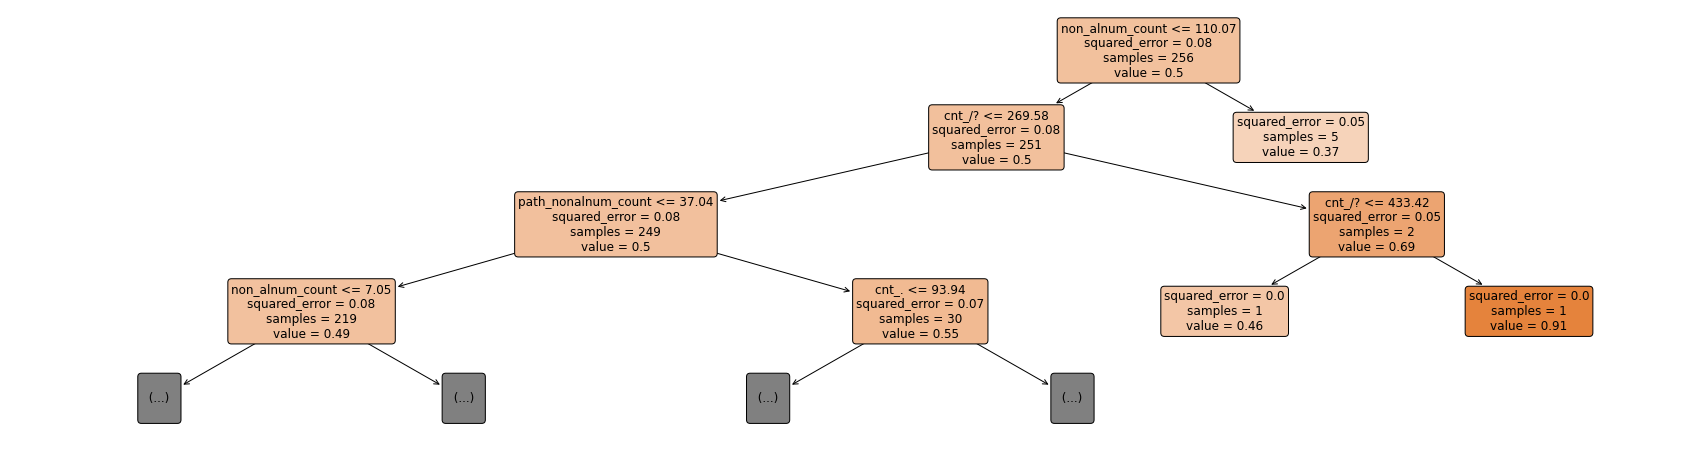

In [ ]:
from sklearn.tree import plot_tree

estimator = clf.estimators_[0]

plt.figure(figsize=(30, 8))
plot_tree(
        estimator,
        max_depth=3,
        feature_names = X_train.columns,
        filled=True,
        rounded=True,
        precision=2,
        fontsize=12,
    )
plt.savefig("tree.png")

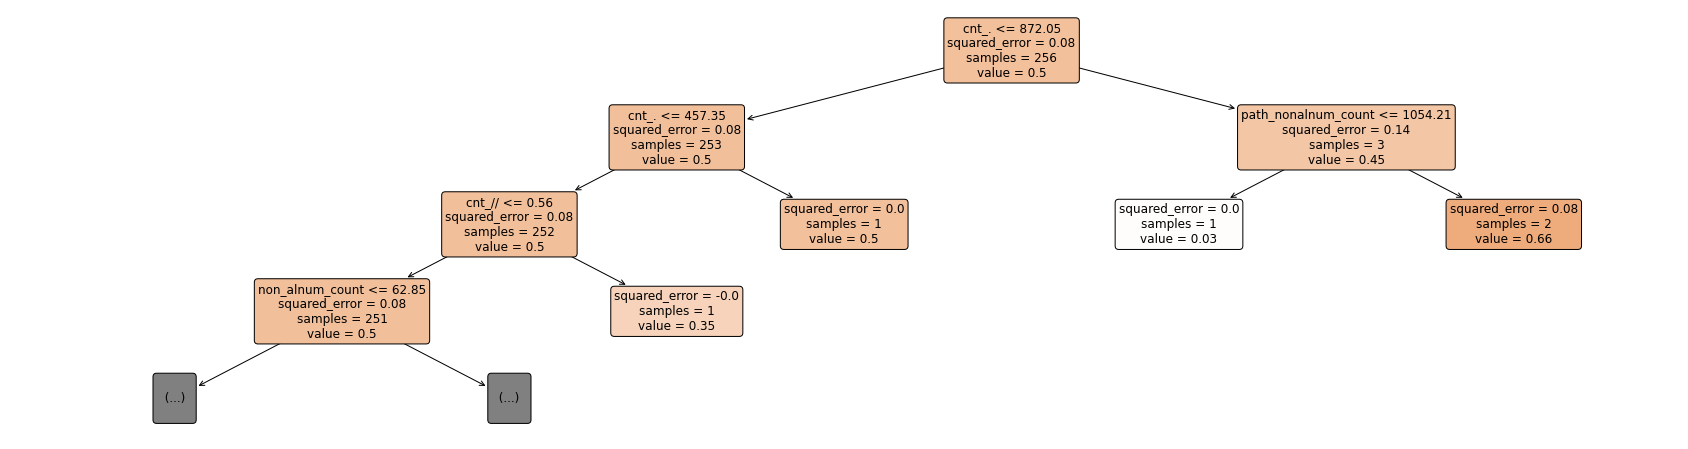

In [ ]:
from sklearn.tree import plot_tree

estimator = clf.estimators_[1]

plt.figure(figsize=(30, 8))
plot_tree(
        estimator,
        max_depth=3,
        feature_names = X_train.columns,
        filled=True,
        rounded=True,
        precision=2,
        fontsize=12,
    )
plt.savefig("tree.png")

### Prediction

In [16]:
y_pred_test = clf.predict(X_test)

In [17]:
# Show Normal request
(test_data_drop[y_pred_test > 0])

,ip,time,request,status,size,referer,user_agent
0,93.104.209.19,2019-01-22 18:54:36+03:30,GET /mysql/admin/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
1,93.104.209.19,2019-01-22 18:54:41+03:30,GET /sqlmanager/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,93.104.209.19,2019-01-22 18:54:47+03:30,GET /sql/phpMyAdmin2/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,185.234.218.74,2019-01-26 05:36:02+03:30,GET /config/database.php.bak HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...


In [18]:
# Show Anormal request
(test_data_drop[y_pred_test < 0])

,ip,time,request,status,size,referer,user_agent
3,62.210.157.10,2019-01-25 21:20:36+03:30,GET /wp-content/plugins/wptf-image-gallery/lib...,301,178,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...
5,185.222.202.118,2019-01-22 09:15:46+03:30,GET /public/index.php?s=/index/%5Cthink%5Capp/...,301,178,NaN,python-requests/2.4.3 CPython/2.7.9 Linux/3.16...
6,118.68.205.57,2019-01-22 11:41:43+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Yowai/2.0
7,218.228.8.49,2019-01-22 11:49:28+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Tsunami/2.0
8,108.61.86.94,2019-01-24 13:08:01+03:30,GET /login.cgi?cli=aa%20aa%27;wget%20http://10...,400,166,NaN,Solstice/2.0
9,149.12.217.220,2019-01-26 13:25:41+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
10,5.101.40.234,2019-01-23 06:53:01+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
11,5.101.40.234,2019-01-23 06:53:17+03:30,GET /image/{{basketItem.id}}?type=%28SELECT%20...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
12,5.101.40.234,2019-01-23 06:53:18+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
13,5.101.40.234,2019-01-23 06:53:56+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...


### Score

In [ ]:
score = clf.decision_function(X_train)

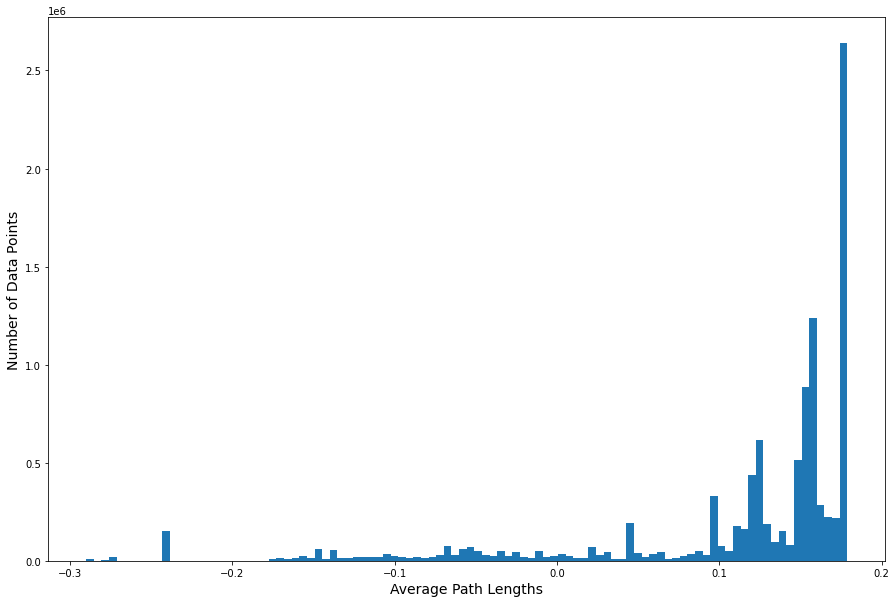

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.hist(score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

In [ ]:
np.savetxt(PATH + 'score_full.csv', score, delimiter=',')

## Chunk data

### Visualization of decision tree

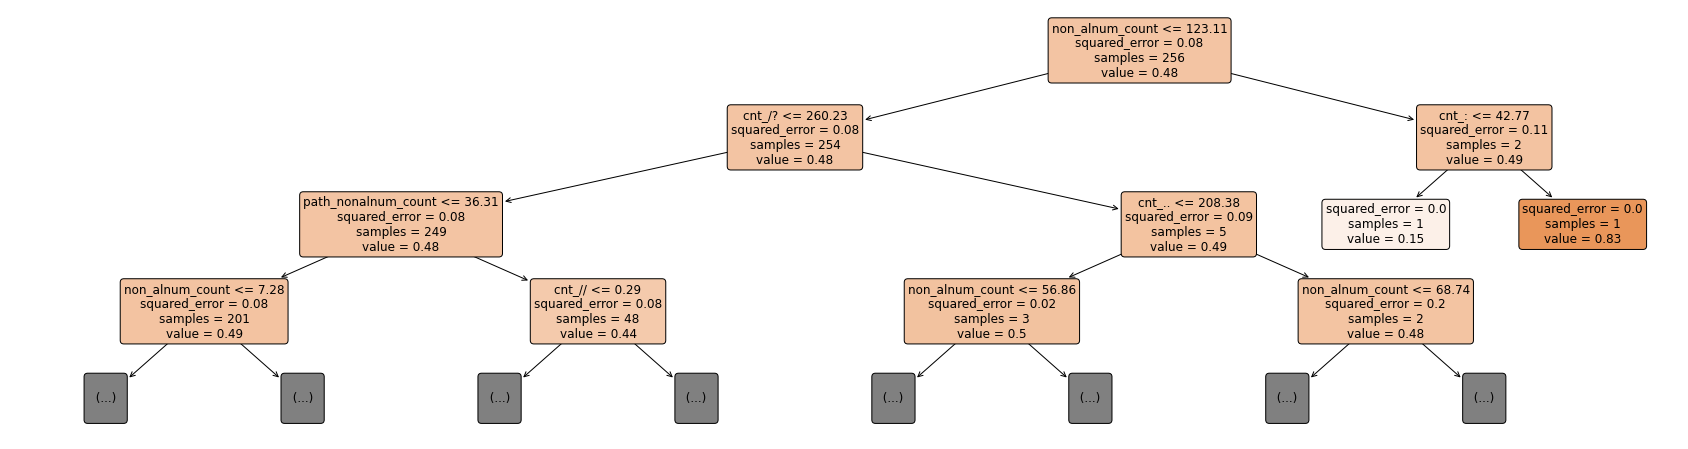

In [ ]:
from sklearn.tree import plot_tree

estimator = clf.estimators_[0]

plt.figure(figsize=(30, 8))
plot_tree(
        estimator,
        max_depth=3,
        feature_names = X_train.columns,
        filled=True,
        rounded=True,
        precision=2,
        fontsize=12,
    )
plt.savefig("tree.png")

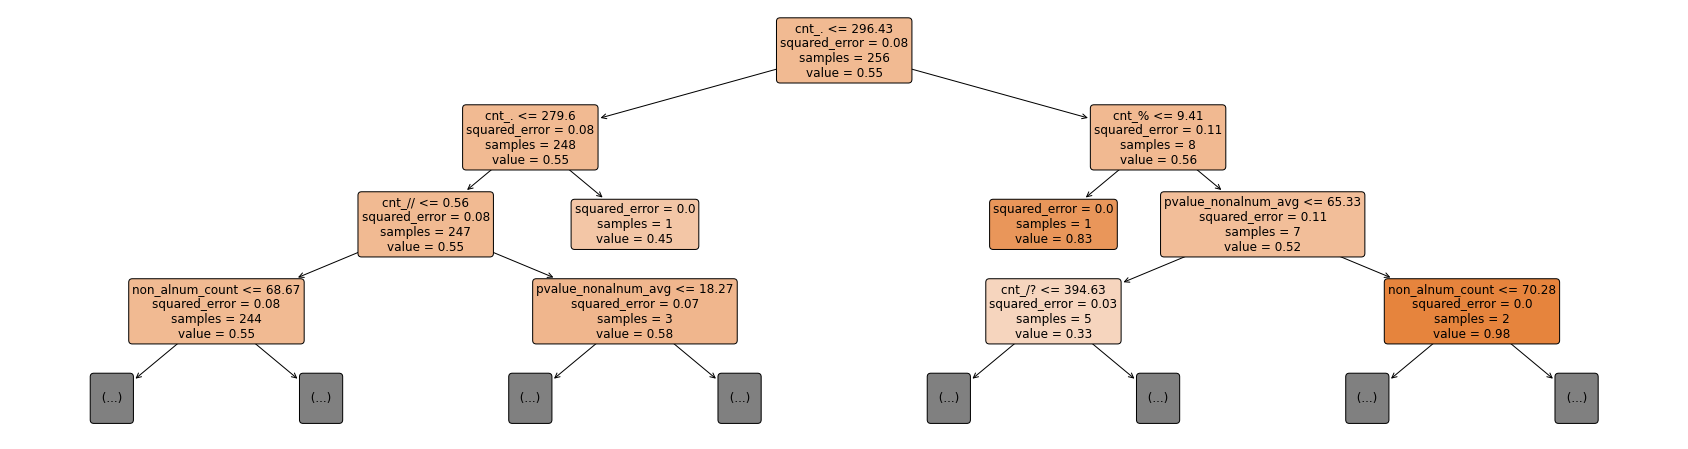

In [ ]:
from sklearn.tree import plot_tree

estimator = clf.estimators_[1]

plt.figure(figsize=(30, 8))
plot_tree(
        estimator,
        max_depth=3,
        feature_names = X_train.columns,
        filled=True,
        rounded=True,
        precision=2,
        fontsize=12,
    )
plt.savefig("tree.png")

### Prediction

In [ ]:
y_pred_test = clf.predict(X_test)

In [ ]:
# Show Normal request
test_data_drop[y_pred_test > 0]

,ip,time,request,status,size,referer,user_agent
0,93.104.209.19,2019-01-22 18:54:36+03:30,GET /mysql/admin/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
1,93.104.209.19,2019-01-22 18:54:41+03:30,GET /sqlmanager/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,93.104.209.19,2019-01-22 18:54:47+03:30,GET /sql/phpMyAdmin2/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,185.234.218.74,2019-01-26 05:36:02+03:30,GET /config/database.php.bak HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...


In [ ]:
# Show Anormal request
test_data_drop[y_pred_test < 0]

,ip,time,request,status,size,referer,user_agent
3,62.210.157.10,2019-01-25 21:20:36+03:30,GET /wp-content/plugins/wptf-image-gallery/lib...,301,178,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...
5,185.222.202.118,2019-01-22 09:15:46+03:30,GET /public/index.php?s=/index/%5Cthink%5Capp/...,301,178,NaN,python-requests/2.4.3 CPython/2.7.9 Linux/3.16...
6,118.68.205.57,2019-01-22 11:41:43+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Yowai/2.0
7,218.228.8.49,2019-01-22 11:49:28+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Tsunami/2.0
8,108.61.86.94,2019-01-24 13:08:01+03:30,GET /login.cgi?cli=aa%20aa%27;wget%20http://10...,400,166,NaN,Solstice/2.0
9,149.12.217.220,2019-01-26 13:25:41+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
10,5.101.40.234,2019-01-23 06:53:01+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
11,5.101.40.234,2019-01-23 06:53:17+03:30,GET /image/{{basketItem.id}}?type=%28SELECT%20...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
12,5.101.40.234,2019-01-23 06:53:18+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
13,5.101.40.234,2019-01-23 06:53:56+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...


### Score

In [ ]:
score = clf.decision_function(X_train)

In [ ]:
score

array([-0.02279195,  0.16758344,  0.16758344, ...,  0.09854243,
        0.16758344,  0.16758344])

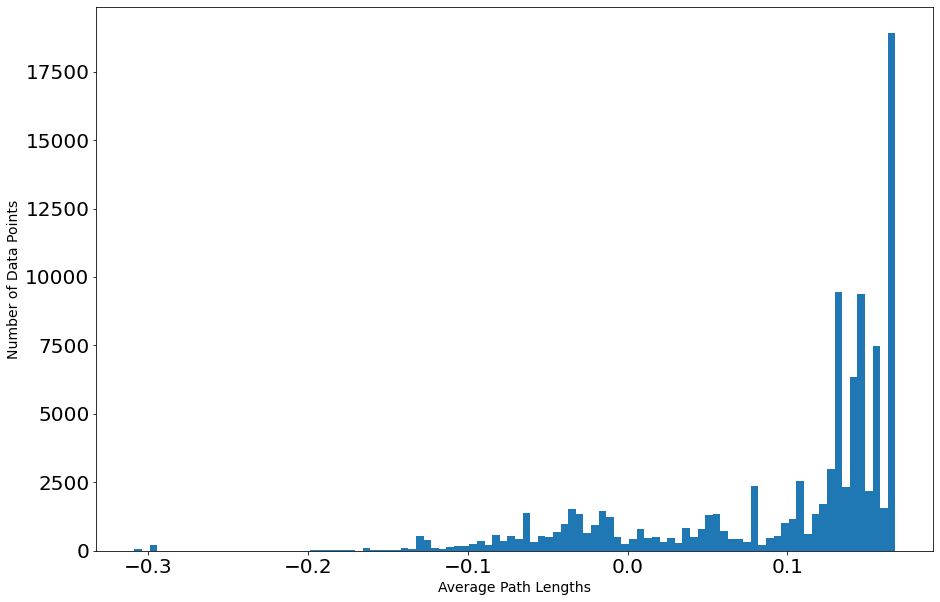

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.hist(score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

In [ ]:
np.savetxt(PATH + 'score_chunk.csv', score, delimiter=',')

In [ ]:
y_pred_score = pd.DataFrame(y_pred_train, columns=['y'])
y_pred_score['score'] = score
y_pred_score

,y,score
0,-1,-0.022792
1,1,0.167583
2,1,0.167583
3,1,0.167583
4,-1,-0.011382
...,...,...
99995,1,0.167583
99996,1,0.167583
99997,1,0.098542
99998,1,0.167583


In [ ]:
y_pred_score[y_pred_score['y'] > 0]

,y,score
1,1,0.167583
2,1,0.167583
3,1,0.167583
5,1,0.167583
6,1,0.167583
...,...,...
99995,1,0.167583
99996,1,0.167583
99997,1,0.098542
99998,1,0.167583


In [ ]:
y_pred_score[y_pred_score['y'] < 0]

,y,score
0,-1,-0.022792
4,-1,-0.011382
12,-1,-0.084578
14,-1,-0.013209
20,-1,-0.012576
...,...,...
99927,-1,-0.063072
99931,-1,-0.030962
99937,-1,-0.118046
99947,-1,-0.063072


# pyod
https://pyod.readthedocs.io/en/latest/

## Installation

In [19]:
!pip install pyod

     |████████████████████████████████| 118 kB 5.2 MB/s 
  Created wheel for pyod: filename=pyod-1.0.0-py3-none-any.whl size=144471 sha256=3ee3e67b07dbcffd4e82f8024b78b1795cdcd1e0ef8c3f8bed0daf157b04b0de
  Stored in directory: /root/.cache/pip/wheels/37/e6/25/8098880dadf78bf063ee9b37477b1a9317e8bb0fc06e623187
Successfully built pyod


## kNN

### Build model

In [ ]:
from pyod.models.knn import KNN

knn = KNN()
knn.fit(X_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

Fitting completed in **6min**

### Prediction

In [ ]:
y_pred_train = knn.predict(X_train)

In [ ]:
y_pred_train

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
# Show Normal request
(data_drop[y_pred_train == 0])[:10]

,ip,time,request,status,size,referer,user_agent
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
10,207.46.13.136,2019-01-22 03:56:18+03:30,GET /product/10214 HTTP/1.1,200,39677,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
11,40.77.167.129,2019-01-22 03:56:19+03:30,GET /image/578/article/100x100 HTTP/1.1,200,9831,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [ ]:
len(data_drop[y_pred_train == 0])

91603

In [ ]:
# Show Anormal request
(data_drop[y_pred_train > 0])[:10]

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
12,178.253.33.51,2019-01-22 03:56:19+03:30,GET /m/product/32574/62991/%D9%85%D8%A7%D8%B4%...,200,20406,https://www.zanbil.ir/m/filter/p5767%2Ct156?na...,Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...
26,5.78.198.52,2019-01-22 03:56:21+03:30,GET /m/product/33978/64784/%DA%AF%D9%88%D8%B4%...,200,21931,https://www.zanbil.ir/m/browse/cell-phone/%DA%...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
29,91.99.72.15,2019-01-22 03:56:21+03:30,GET /product/7793/9663/%D9%85%D8%A7%DB%8C%DA%A...,200,40889,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
34,54.36.149.70,2019-01-22 03:56:22+03:30,"GET /filter/b215,b400,p5686,v1|%D8%B3%D9%81%DB...",200,30673,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
94,54.36.148.87,2019-01-22 03:56:34+03:30,GET /filter/p65%2Cv1%7C%D9%86%D9%82%D8%B1%D9%8...,302,0,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
95,17.58.102.43,2019-01-22 03:56:35+03:30,GET /filter/b571%2Cb288%2Cb70%2Cb57%2Cb6%2Cb35...,200,37759,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...
97,66.249.66.194,2019-01-22 03:56:35+03:30,GET /m/product/17369/48780/%DB%8C%D8%AE%DA%86%...,200,20863,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...
101,51.15.15.54,2019-01-22 03:56:38+03:30,GET /blog/tag/%DA%AF%D8%AC%D8%AA/ HTTP/1.1,200,21391,NaN,Barkrowler/0.9 (+http://www.exensa.com/crawl)


In [ ]:
len(data_drop[y_pred_train > 0])

8397

### Evaluation

#### Prediction

In [ ]:
y_pred_test = knn.predict(X_test)

In [ ]:
# Show Normal request
test_data_drop[y_pred_test == 0]

,ip,time,request,status,size,referer,user_agent
0,93.104.209.19,2019-01-22 18:54:36+03:30,GET /mysql/admin/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
1,93.104.209.19,2019-01-22 18:54:41+03:30,GET /sqlmanager/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,93.104.209.19,2019-01-22 18:54:47+03:30,GET /sql/phpMyAdmin2/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,185.234.218.74,2019-01-26 05:36:02+03:30,GET /config/database.php.bak HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...


In [ ]:
# Show Anormal request
test_data_drop[y_pred_test > 0]

,ip,time,request,status,size,referer,user_agent
3,62.210.157.10,2019-01-25 21:20:36+03:30,GET /wp-content/plugins/wptf-image-gallery/lib...,301,178,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...
5,185.222.202.118,2019-01-22 09:15:46+03:30,GET /public/index.php?s=/index/%5Cthink%5Capp/...,301,178,NaN,python-requests/2.4.3 CPython/2.7.9 Linux/3.16...
6,118.68.205.57,2019-01-22 11:41:43+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Yowai/2.0
7,218.228.8.49,2019-01-22 11:49:28+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Tsunami/2.0
8,108.61.86.94,2019-01-24 13:08:01+03:30,GET /login.cgi?cli=aa%20aa%27;wget%20http://10...,400,166,NaN,Solstice/2.0
9,149.12.217.220,2019-01-26 13:25:41+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
10,5.101.40.234,2019-01-23 06:53:01+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
11,5.101.40.234,2019-01-23 06:53:17+03:30,GET /image/{{basketItem.id}}?type=%28SELECT%20...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
12,5.101.40.234,2019-01-23 06:53:18+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
13,5.101.40.234,2019-01-23 06:53:56+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...


#### Score

In [ ]:
score = knn.decision_function(X_train)

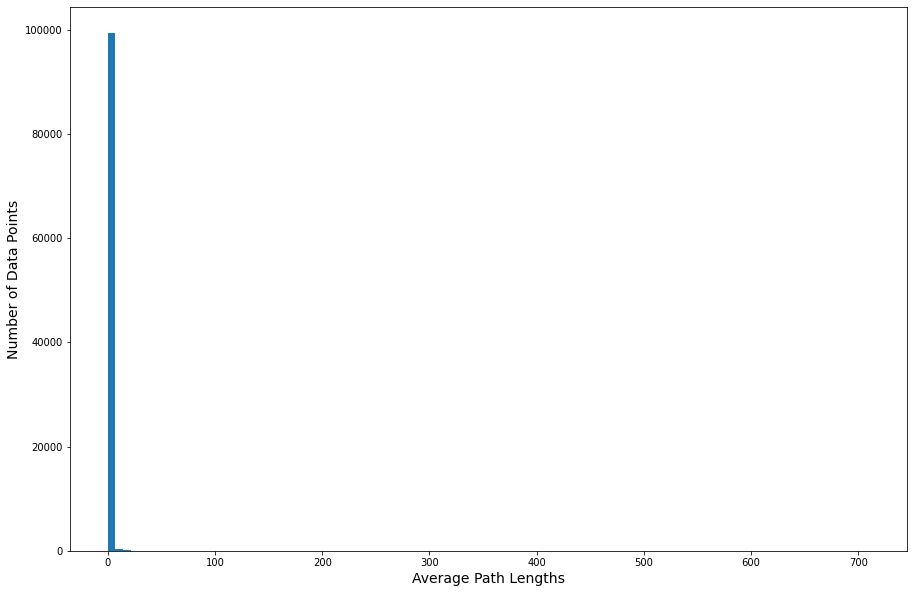

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.hist(score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

## INNE
Isolation-based Anomaly Detection Using Nearest-Neighbor Ensembles

### Preparation

In [ ]:
!pip install inne

### Build model

In [ ]:
from inne import IsolationNNE

inne = IsolationNNE(n_estimators=1000)
inne.fit(X_train)

/usr/local/lib/python3.7/dist-packages/inne/_inne.py:165: RuntimeWarning: invalid value encountered in true_divide
  self._ratio[i] = 1 - conn_radius / self._center_radius[i]
/usr/local/lib/python3.7/dist-packages/inne/_inne.py:165: RuntimeWarning: invalid value encountered in true_divide
  self._ratio[i] = 1 - conn_radius / self._center_radius[i]
/usr/local/lib/python3.7/dist-packages/inne/_inne.py:165: RuntimeWarning: invalid value encountered in true_divide
  self._ratio[i] = 1 - conn_radius / self._center_radius[i]
/usr/local/lib/python3.7/dist-packages/inne/_inne.py:165: RuntimeWarning: invalid value encountered in true_divide
  self._ratio[i] = 1 - conn_radius / self._center_radius[i]
/usr/local/lib/python3.7/dist-packages/inne/_inne.py:165: RuntimeWarning: invalid value encountered in true_divide
  self._ratio[i] = 1 - conn_radius / self._center_radius[i]
/usr/local/lib/python3.7/dist-packages/inne/_inne.py:165: RuntimeWarning: invalid value encountered in true_divide
  self._ra

IsolationNNE(max_samples=16, n_estimators=1000)

### Prediction

In [ ]:
y_pred_train = inne.predict(X_train)

In [ ]:
y_pred_train

array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
# Show Normal request
(data_drop[y_pred_train > 0])[:10]

,ip,time,request,status,size,referer,user_agent


In [ ]:
# Show Anormal request
(data_drop[y_pred_train < 0])[:10]

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


### Evaluation

In [ ]:
score = inne.decision_function(X_train)

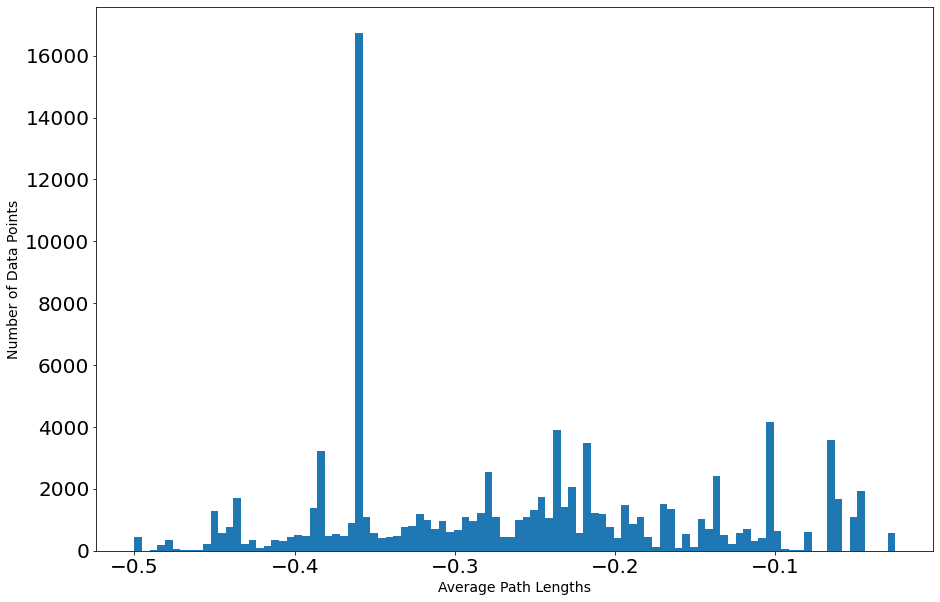

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.hist(score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

## LODA
Lightweight On-line Detector of Anomalies

### Build model

#### Full data

In [20]:
from pyod.models.loda import LODA
loda = LODA()
loda.fit(X_train)

LODA(contamination=0.1, n_bins=10, n_random_cuts=100)

Fitting completed in **1min**

#### Chunk data

In [ ]:
from pyod.models.loda import LODA
loda = LODA()
loda.fit(X_train)

LODA(contamination=0.1, n_bins=10, n_random_cuts=100)

Fitting completed in **2sec**

### Prediction

#### Full data

In [21]:
y_pred_train = loda.predict(X_train)

**58sec**

In [22]:
# Show Normal request
(data_drop[y_pred_train == 0])[:10]

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [23]:
# Show Anormal request
(data_drop[y_pred_train == 1])[:10]

,ip,time,request,status,size,referer,user_agent
26,5.78.198.52,2019-01-22 03:56:21+03:30,GET /m/product/33978/64784/%DA%AF%D9%88%D8%B4%...,200,21931,https://www.zanbil.ir/m/browse/cell-phone/%DA%...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
33,34.247.132.53,2019-01-22 03:56:22+03:30,GET / HTTP/1.1,200,29619,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
51,5.78.198.52,2019-01-22 03:56:26+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
55,5.78.198.52,2019-01-22 03:56:27+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
59,5.78.198.52,2019-01-22 03:56:28+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
62,5.78.198.52,2019-01-22 03:56:29+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
77,5.78.198.52,2019-01-22 03:56:30+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,394,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
88,5.78.198.52,2019-01-22 03:56:32+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
89,2.179.141.98,2019-01-22 03:56:32+03:30,"POST /ajaxFilter/p65,b1?page=1 HTTP/1.1",200,5409,"https://www.zanbil.ir/filter/p65,b1?page=0",Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
91,5.78.198.52,2019-01-22 03:56:33+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...


#### Chunk data

In [ ]:
y_pred_train = loda.predict(X_train)

In [ ]:
y_pred_train

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Show Normal request
(data_drop[y_pred_train == 0])[:10]

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [ ]:
len(data_drop[y_pred_train == 0])

90000

In [ ]:
# Show Anormal request
(data_drop[y_pred_train == 1])[:10]

,ip,time,request,status,size,referer,user_agent
47,2.177.12.140,2019-01-22 03:56:25+03:30,GET /static/images/amp/third-party/footer-mobi...,200,62894,https://www.zanbil.ir/m/product/33606/%D8%AA%D...,Mozilla/5.0 (Android 7.1.1; Mobile; rv:64.0) G...
53,66.249.66.91,2019-01-22 03:56:27+03:30,GET /filter/b656%2Cb703%2Cb67%2Cb226%2Cb41%2Cb...,200,41228,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
69,66.111.54.249,2019-01-22 03:56:29+03:30,GET /static/css/font/wyekan/font.woff HTTP/1.1,200,28536,https://www.zanbil.ir/m/filter/b1%2Cp1?page=1,Mozilla/5.0 (Linux; Android 5.0; SM-G900H Buil...
79,66.249.66.91,2019-01-22 03:56:30+03:30,GET /filter/b481%2Cb43%2Cb874%2Cb32%2Cb67%2Cb3...,200,39665,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
82,66.249.66.91,2019-01-22 03:56:31+03:30,GET /filter/b481%2Cb874%2Cb226%2Cb570%2Cb598%2...,200,41329,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
105,66.249.66.91,2019-01-22 03:56:38+03:30,GET /filter/b481%2Cb874%2Cb226%2Cb570%2Cb598%2...,200,41218,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
106,31.56.96.51,2019-01-22 03:56:38+03:30,GET /static/images/amp/third-party/footer-mobi...,200,62894,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
108,66.249.66.91,2019-01-22 03:56:39+03:30,GET /filter/b656%2Cb703%2Cb67%2Cb226%2Cb41%2Cb...,200,41513,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
139,66.249.66.91,2019-01-22 03:56:46+03:30,GET /filter/b36%2Cb41%2Cb598%2Cb168%2Cb103%2Cb...,200,32624,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
154,66.249.66.91,2019-01-22 03:56:48+03:30,GET /filter/b656%2Cb703%2Cb32%2Cb67%2Cb226%2Cb...,200,41332,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...


In [ ]:
len(data_drop[y_pred_train == 1])

10000

### Evaluation

#### Full data

##### Prediction

In [24]:
y_pred_test = loda.predict(X_test)

In [25]:
# Show Normal request
test_data_drop[y_pred_test == 0]

,ip,time,request,status,size,referer,user_agent
0,93.104.209.19,2019-01-22 18:54:36+03:30,GET /mysql/admin/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
1,93.104.209.19,2019-01-22 18:54:41+03:30,GET /sqlmanager/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,93.104.209.19,2019-01-22 18:54:47+03:30,GET /sql/phpMyAdmin2/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,185.234.218.74,2019-01-26 05:36:02+03:30,GET /config/database.php.bak HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...
5,185.222.202.118,2019-01-22 09:15:46+03:30,GET /public/index.php?s=/index/%5Cthink%5Capp/...,301,178,NaN,python-requests/2.4.3 CPython/2.7.9 Linux/3.16...
8,108.61.86.94,2019-01-24 13:08:01+03:30,GET /login.cgi?cli=aa%20aa%27;wget%20http://10...,400,166,NaN,Solstice/2.0
11,5.101.40.234,2019-01-23 06:53:17+03:30,GET /image/{{basketItem.id}}?type=%28SELECT%20...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
13,5.101.40.234,2019-01-23 06:53:56+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
14,176.121.14.183,2019-01-25 12:09:18+03:30,GET /image/29000?name=%28SELECT%206608%20FROM%...,200,94646,NaN,Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9...


In [26]:
# Show Anormal request
test_data_drop[y_pred_test > 0]

,ip,time,request,status,size,referer,user_agent
3,62.210.157.10,2019-01-25 21:20:36+03:30,GET /wp-content/plugins/wptf-image-gallery/lib...,301,178,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...
6,118.68.205.57,2019-01-22 11:41:43+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Yowai/2.0
7,218.228.8.49,2019-01-22 11:49:28+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Tsunami/2.0
9,149.12.217.220,2019-01-26 13:25:41+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
10,5.101.40.234,2019-01-23 06:53:01+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
12,5.101.40.234,2019-01-23 06:53:18+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...


##### Score

In [ ]:
score = loda.decision_function(X_train)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.hist(score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

#### Chunk data

##### Prediction

In [ ]:
y_pred_test = loda.predict(X_test)

In [ ]:
# Show Normal request
test_data_drop[y_pred_test == 0]

,ip,time,request,status,size,referer,user_agent
0,93.104.209.19,2019-01-22 18:54:36+03:30,GET /mysql/admin/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
1,93.104.209.19,2019-01-22 18:54:41+03:30,GET /sqlmanager/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,93.104.209.19,2019-01-22 18:54:47+03:30,GET /sql/phpMyAdmin2/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,185.234.218.74,2019-01-26 05:36:02+03:30,GET /config/database.php.bak HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...
5,185.222.202.118,2019-01-22 09:15:46+03:30,GET /public/index.php?s=/index/%5Cthink%5Capp/...,301,178,NaN,python-requests/2.4.3 CPython/2.7.9 Linux/3.16...
13,5.101.40.234,2019-01-23 06:53:56+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...


In [ ]:
# Show Anormal request
test_data_drop[y_pred_test > 0]

,ip,time,request,status,size,referer,user_agent
3,62.210.157.10,2019-01-25 21:20:36+03:30,GET /wp-content/plugins/wptf-image-gallery/lib...,301,178,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...
6,118.68.205.57,2019-01-22 11:41:43+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Yowai/2.0
7,218.228.8.49,2019-01-22 11:49:28+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Tsunami/2.0
8,108.61.86.94,2019-01-24 13:08:01+03:30,GET /login.cgi?cli=aa%20aa%27;wget%20http://10...,400,166,NaN,Solstice/2.0
9,149.12.217.220,2019-01-26 13:25:41+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
10,5.101.40.234,2019-01-23 06:53:01+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
11,5.101.40.234,2019-01-23 06:53:17+03:30,GET /image/{{basketItem.id}}?type=%28SELECT%20...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
12,5.101.40.234,2019-01-23 06:53:18+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
14,176.121.14.183,2019-01-25 12:09:18+03:30,GET /image/29000?name=%28SELECT%206608%20FROM%...,200,94646,NaN,Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9...


##### Score

In [ ]:
score = loda.decision_function(X_train)

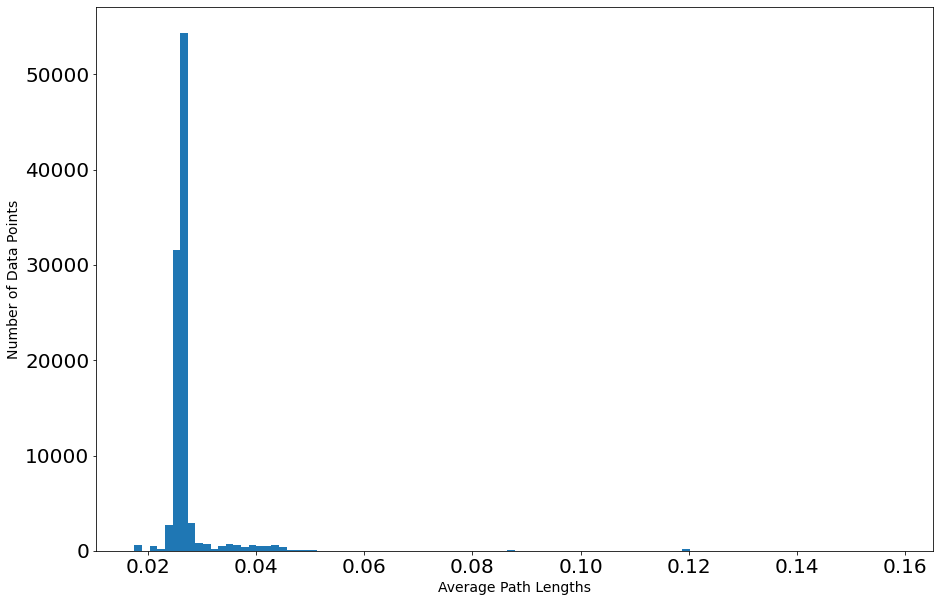

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.hist(score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

## ABOD

### Build model

In [ ]:
from pyod.models.abod import ABOD

abod = ABOD()
abod.fit(X_train)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ABOD(contamination=0.1, method='fast', n_neighbors=5)

### Prediction

In [ ]:
y_pred_train = abod.predict(X_train)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
y_pred_train

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Show normal request
(data_drop[y_pred_train == 0])[:10]

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [ ]:
# Show Anormal request
(data_drop[y_pred_train > 0])[:10]

,ip,time,request,status,size,referer,user_agent


## AutoEncoder

### Build model

In [ ]:
from pyod.models.auto_encoder import AutoEncoder
ae = AutoEncoder(hidden_neurons=[29])
ae.fit(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dropout (Dropout)           (None, 29)                0         
                                                                 
 dense_1 (Dense)             (None, 29)                870       
                                                                 
 dropout_1 (Dropout)         (None, 29)                0         
                                                                 
 dense_2 (Dense)             (None, 29)                870       
                                                                 
 dropout_2 (Dropout)         (None, 29)                0         
                                                                 
 dense_3 (Dense)             (None, 29)                8

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[29], l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f8f8f0843b0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

Fitting completed in **12min**

### Prediction

In [ ]:
y_pred_train = ae.predict(X_train)

In [ ]:
y_pred_train

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
len(y_pred_train)

100000

In [ ]:
# Show normal request
(data_drop[y_pred_train == 0])[:10]

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [ ]:
len(data_drop[y_pred_train == 0])

90001

In [ ]:
# Show Anormal request
(data_drop[y_pred_train > 0])[:10]

,ip,time,request,status,size,referer,user_agent
12,178.253.33.51,2019-01-22 03:56:19+03:30,GET /m/product/32574/62991/%D9%85%D8%A7%D8%B4%...,200,20406,https://www.zanbil.ir/m/filter/p5767%2Ct156?na...,Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...
26,5.78.198.52,2019-01-22 03:56:21+03:30,GET /m/product/33978/64784/%DA%AF%D9%88%D8%B4%...,200,21931,https://www.zanbil.ir/m/browse/cell-phone/%DA%...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
33,34.247.132.53,2019-01-22 03:56:22+03:30,GET / HTTP/1.1,200,29619,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
51,5.78.198.52,2019-01-22 03:56:26+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
53,66.249.66.91,2019-01-22 03:56:27+03:30,GET /filter/b656%2Cb703%2Cb67%2Cb226%2Cb41%2Cb...,200,41228,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
55,5.78.198.52,2019-01-22 03:56:27+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
59,5.78.198.52,2019-01-22 03:56:28+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
62,5.78.198.52,2019-01-22 03:56:29+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
77,5.78.198.52,2019-01-22 03:56:30+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,394,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
79,66.249.66.91,2019-01-22 03:56:30+03:30,GET /filter/b481%2Cb43%2Cb874%2Cb32%2Cb67%2Cb3...,200,39665,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...


In [ ]:
len(data_drop[y_pred_train > 0])

9999

### Evaluation

#### Prediction

In [ ]:
y_pred_test = ae.predict(X_test)

In [ ]:
# Show Normal request
test_data_drop[y_pred_test == 0]

,ip,time,request,status,size,referer,user_agent
0,93.104.209.19,2019-01-22 18:54:36+03:30,GET /mysql/admin/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
1,93.104.209.19,2019-01-22 18:54:41+03:30,GET /sqlmanager/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,93.104.209.19,2019-01-22 18:54:47+03:30,GET /sql/phpMyAdmin2/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,185.234.218.74,2019-01-26 05:36:02+03:30,GET /config/database.php.bak HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...


In [ ]:
# Show Anormal request
test_data_drop[y_pred_test > 0]

,ip,time,request,status,size,referer,user_agent
3,62.210.157.10,2019-01-25 21:20:36+03:30,GET /wp-content/plugins/wptf-image-gallery/lib...,301,178,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...
5,185.222.202.118,2019-01-22 09:15:46+03:30,GET /public/index.php?s=/index/%5Cthink%5Capp/...,301,178,NaN,python-requests/2.4.3 CPython/2.7.9 Linux/3.16...
6,118.68.205.57,2019-01-22 11:41:43+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Yowai/2.0
7,218.228.8.49,2019-01-22 11:49:28+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Tsunami/2.0
8,108.61.86.94,2019-01-24 13:08:01+03:30,GET /login.cgi?cli=aa%20aa%27;wget%20http://10...,400,166,NaN,Solstice/2.0
9,149.12.217.220,2019-01-26 13:25:41+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
10,5.101.40.234,2019-01-23 06:53:01+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
11,5.101.40.234,2019-01-23 06:53:17+03:30,GET /image/{{basketItem.id}}?type=%28SELECT%20...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
12,5.101.40.234,2019-01-23 06:53:18+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
13,5.101.40.234,2019-01-23 06:53:56+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...


#### Score

In [ ]:
score = ae.decision_function(X_train)

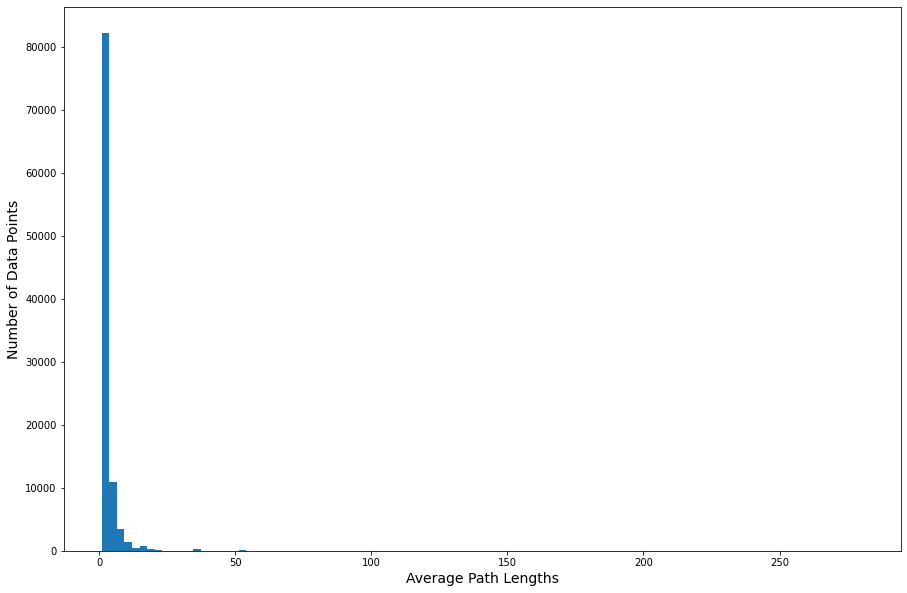

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.hist(score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

## DeepSVDD

### Build model

In [ ]:
from pyod.models.deep_svdd import DeepSVDD
svdd = DeepSVDD()
svdd.fit(X_train)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_1 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_1 (TFOpL  (None,)                  0         
 ambda)                                                    

DeepSVDD(batch_size=32,
     c=array([0.17508, 0.25615, 0.17153, 0.26295, 0.18982, 0.2157 , 0.11318,
       0.14653, 0.16744, 0.35667, 0.1    , 0.19948, 0.1    , 0.10822,
       0.14192, 0.1    , 0.1    , 0.1    , 0.1    , 0.1    , 0.38239,
       0.1    , 0.22506, 0.1    , 0.18751, 0.10579, 0.1    , 0.1    ,
       0.21492, 0.12062, 0.20129, 0.1    ], dtype=float32),
     contamination=0.1, dropout_rate=0.2, epochs=100,
     hidden_activation='relu', hidden_neurons=[64, 32], l2_regularizer=0.1,
     optimizer='adam', output_activation='sigmoid', preprocessing=True,
     random_state=None, use_ae=False, validation_size=0.1, verbose=1)

Fitting completed in **11min**

### Prediction

In [ ]:
y_pred_train = svdd.predict(X_train)

In [ ]:
y_pred_train

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Show normal request
(data_drop[y_pred_train == 0])[:10]

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [ ]:
# Show Anormal request
(data_drop[y_pred_train > 0])[:10]

,ip,time,request,status,size,referer,user_agent
33,34.247.132.53,2019-01-22 03:56:22+03:30,GET / HTTP/1.1,200,29619,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
47,2.177.12.140,2019-01-22 03:56:25+03:30,GET /static/images/amp/third-party/footer-mobi...,200,62894,https://www.zanbil.ir/m/product/33606/%D8%AA%D...,Mozilla/5.0 (Android 7.1.1; Mobile; rv:64.0) G...
51,5.78.198.52,2019-01-22 03:56:26+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
55,5.78.198.52,2019-01-22 03:56:27+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
59,5.78.198.52,2019-01-22 03:56:28+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
62,5.78.198.52,2019-01-22 03:56:29+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
63,66.111.54.249,2019-01-22 03:56:29+03:30,GET /static/images/guarantees/goodShopping.png...,200,6496,https://www.zanbil.ir/m/filter/b1%2Cp1?page=1,Mozilla/5.0 (Linux; Android 5.0; SM-G900H Buil...
66,66.111.54.249,2019-01-22 03:56:29+03:30,GET /static/images/guarantees/bestPrice.png HT...,200,7356,https://www.zanbil.ir/m/filter/b1%2Cp1?page=1,Mozilla/5.0 (Linux; Android 5.0; SM-G900H Buil...
72,66.111.54.249,2019-01-22 03:56:29+03:30,GET /static/images/guarantees/fastDelivery.png...,200,7713,https://www.zanbil.ir/m/filter/b1%2Cp1?page=1,Mozilla/5.0 (Linux; Android 5.0; SM-G900H Buil...
77,5.78.198.52,2019-01-22 03:56:30+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,394,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...


### Evaluation

#### Prediction

In [ ]:
y_pred_test = svdd.predict(X_test)

In [ ]:
# Show Normal request
test_data_drop[y_pred_test == 0]

,ip,time,request,status,size,referer,user_agent
1,93.104.209.19,2019-01-22 18:54:36+03:30,GET /mysql/admin/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,93.104.209.19,2019-01-22 18:54:41+03:30,GET /sqlmanager/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
3,93.104.209.19,2019-01-22 18:54:47+03:30,GET /sql/phpMyAdmin2/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
10,62.210.157.10,2019-01-25 21:20:36+03:30,GET /wp-content/plugins/wptf-image-gallery/lib...,301,178,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...
11,185.234.218.74,2019-01-26 05:36:02+03:30,GET /config/database.php.bak HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...


In [ ]:
# Show Anormal request
test_data_drop[y_pred_test > 0]

,ip,time,request,status,size,referer,user_agent
0,185.222.202.118,2019-01-22 09:15:46+03:30,GET /public/index.php?s=/index/%5Cthink%5Capp/...,301,178,NaN,python-requests/2.4.3 CPython/2.7.9 Linux/3.16...
4,149.12.217.220,2019-01-26 13:25:41+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
5,206.248.167.234,2019-01-26 00:57:39+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
6,5.101.40.234,2019-01-23 06:53:01+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
7,5.101.40.234,2019-01-23 06:53:02+03:30,GET /image/{{basketItem.id}}?type=productModel...,200,5,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
8,5.101.40.234,2019-01-23 06:53:18+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
9,108.61.86.94,2019-01-24 13:08:01+03:30,GET /login.cgi?cli=aa%20aa%27;wget%20http://10...,400,166,NaN,Solstice/2.0


#### Score

In [ ]:
score = svdd.decision_function(X_train)

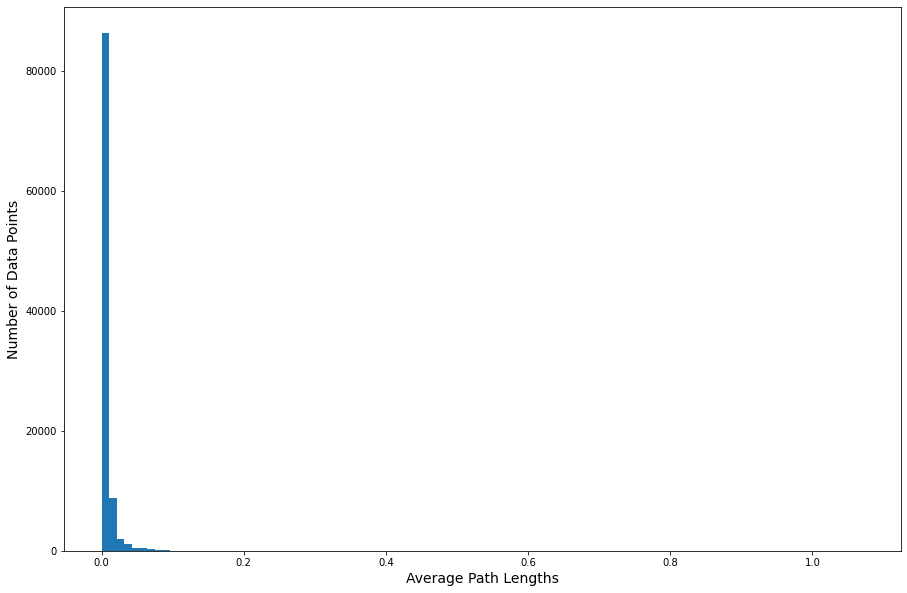

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.hist(score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

## DeepSVDD (Custom)

### Build model

In [ ]:
from pyod.models.deep_svdd import DeepSVDD
svdd2 = DeepSVDD(hidden_neurons=[29])
svdd2.fit(X_train)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_7 (Dense)             (None, 29)                841       
                                                                 
 net_output (Dense)          (None, 29)                841       
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 29)               0         
 bda)                                                            
                                                                 
 tf.math.pow_3 (TFOpLambda)  (None, 29)                0         
                                                                 
 tf.math.reduce_sum_3 (TFOpL  (None,)                  0         
 ambda)                                                    

DeepSVDD(batch_size=32,
     c=array([0.1    , 0.1    , 0.14106, 0.1    , 0.40638, 0.1    , 0.1    ,
       0.15651, 0.1    , 0.34365, 0.1    , 0.1    , 0.1    , 0.38292,
       0.1    , 0.1    , 0.25288, 0.56467, 0.1    , 0.1    , 0.1    ,
       0.25662, 0.20653, 0.41266, 0.12854, 0.19805, 0.14662, 0.1    ,
       0.21522], dtype=float32),
     contamination=0.1, dropout_rate=0.2, epochs=100,
     hidden_activation='relu', hidden_neurons=[29], l2_regularizer=0.1,
     optimizer='adam', output_activation='sigmoid', preprocessing=True,
     random_state=None, use_ae=False, validation_size=0.1, verbose=1)

Fitting completed in **10min**

### Prediction

In [ ]:
y_pred_train = svdd2.predict(X_train)

In [ ]:
# Show normal request
(data_drop[y_pred_train == 0])[:10]

,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7...",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
10,207.46.13.136,2019-01-22 03:56:18+03:30,GET /product/10214 HTTP/1.1,200,39677,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


In [ ]:
len(data_drop[y_pred_train == 0])

90414

In [ ]:
# Show Anormal request
(data_drop[y_pred_train > 0])[:10]

,ip,time,request,status,size,referer,user_agent
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
12,178.253.33.51,2019-01-22 03:56:19+03:30,GET /m/product/32574/62991/%D9%85%D8%A7%D8%B4%...,200,20406,https://www.zanbil.ir/m/filter/p5767%2Ct156?na...,Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...
14,91.99.72.15,2019-01-22 03:56:19+03:30,GET /product/10075/13903/%D9%85%D8%A7%DB%8C%DA...,200,41725,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
20,91.99.72.15,2019-01-22 03:56:20+03:30,GET /product/32798/63266/%DB%8C%D8%AE%DA%86%D8...,200,40250,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
26,5.78.198.52,2019-01-22 03:56:21+03:30,GET /m/product/33978/64784/%DA%AF%D9%88%D8%B4%...,200,21931,https://www.zanbil.ir/m/browse/cell-phone/%DA%...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
29,91.99.72.15,2019-01-22 03:56:21+03:30,GET /product/7793/9663/%D9%85%D8%A7%DB%8C%DA%A...,200,40889,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
32,66.249.66.194,2019-01-22 03:56:22+03:30,GET /m/article/608/%D8%B9%D9%84%D8%AA-%D8%B5%D...,200,20785,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...
33,34.247.132.53,2019-01-22 03:56:22+03:30,GET / HTTP/1.1,200,29619,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
51,5.78.198.52,2019-01-22 03:56:26+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
55,5.78.198.52,2019-01-22 03:56:27+03:30,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...


In [ ]:
len(data_drop[y_pred_train > 0])

9586

### Evaluation

#### Prediction

In [ ]:
y_pred_test = svdd2.predict(X_test)

In [ ]:
# Show Normal request
test_data_drop[y_pred_test == 0]

,ip,time,request,status,size,referer,user_agent
0,93.104.209.19,2019-01-22 18:54:36+03:30,GET /mysql/admin/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
1,93.104.209.19,2019-01-22 18:54:41+03:30,GET /sqlmanager/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,93.104.209.19,2019-01-22 18:54:47+03:30,GET /sql/phpMyAdmin2/index.php?lang=en HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,185.234.218.74,2019-01-26 05:36:02+03:30,GET /config/database.php.bak HTTP/1.1,301,178,NaN,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...
13,5.101.40.234,2019-01-23 06:53:56+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...


In [ ]:
# Show Anormal request
test_data_drop[y_pred_test > 0]

,ip,time,request,status,size,referer,user_agent
3,62.210.157.10,2019-01-25 21:20:36+03:30,GET /wp-content/plugins/wptf-image-gallery/lib...,301,178,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...
5,185.222.202.118,2019-01-22 09:15:46+03:30,GET /public/index.php?s=/index/%5Cthink%5Capp/...,301,178,NaN,python-requests/2.4.3 CPython/2.7.9 Linux/3.16...
6,118.68.205.57,2019-01-22 11:41:43+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Yowai/2.0
7,218.228.8.49,2019-01-22 11:49:28+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Tsunami/2.0
8,108.61.86.94,2019-01-24 13:08:01+03:30,GET /login.cgi?cli=aa%20aa%27;wget%20http://10...,400,166,NaN,Solstice/2.0
9,149.12.217.220,2019-01-26 13:25:41+03:30,GET /index.php?s=/index/\x09hink\x07pp/invokef...,400,166,NaN,Hotaru
10,5.101.40.234,2019-01-23 06:53:01+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
11,5.101.40.234,2019-01-23 06:53:17+03:30,GET /image/{{basketItem.id}}?type=%28SELECT%20...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
12,5.101.40.234,2019-01-23 06:53:18+03:30,GET /image/{{basketItem.id}}?type=productModel...,301,178,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
14,176.121.14.183,2019-01-25 12:09:18+03:30,GET /image/29000?name=%28SELECT%206608%20FROM%...,200,94646,NaN,Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9...


#### Score

In [ ]:
score = svdd2.decision_function(X_train)

In [ ]:
score

array([0.01957311, 0.00713953, 0.00713953, ..., 0.00816908, 0.00713949,
       0.00713949], dtype=float32)

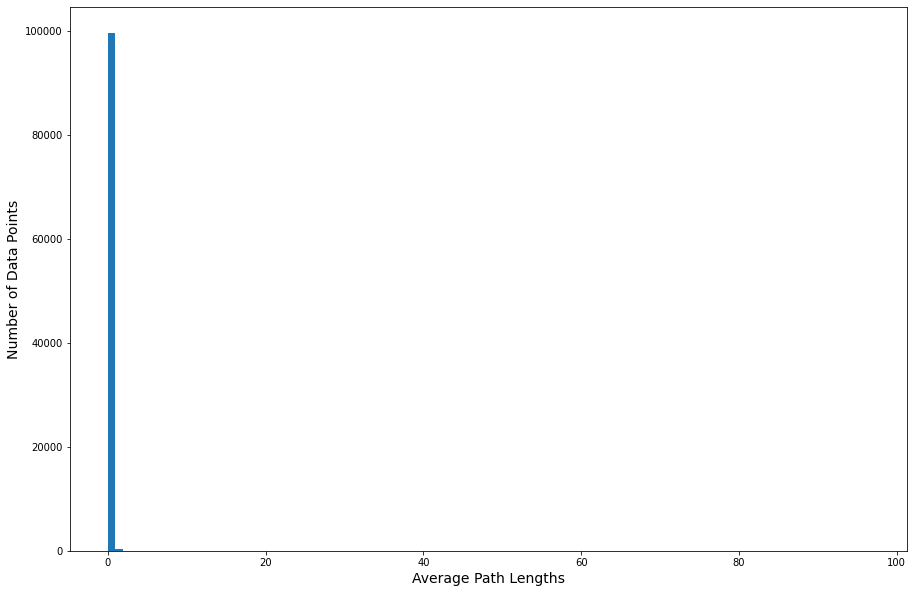

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.hist(score, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

# DBSCAN
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

### Build model

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

db = DBSCAN(eps=3, min_samples=2)
db.fit(X_train)

DBSCAN(eps=3, min_samples=2)

### Prediction

In [ ]:
y_pred_train = db.fit_predict(X_train)

In [ ]:
# Show Normal request
(data_drop[y_pred_train > 0])[:10]

,ip,time,request,status,size,referer,user_agent
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,"Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36"
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,"Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36"
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%D8%B1-%D8%AE%D8%A7%D9%86%DA%AF%DB%8C-%D9%BE%D8%B1%D9%86%D8%B3%D9%84%DB%8C-%D9%85%D8%AF%D9%84-PR257AT HTTP/1.1,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16.0)Gecko/16.0 Firefox/16.0
5,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/23488/productModel/150x150 HTTP/1.1,200,2654,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)
6,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/45437/productModel/150x150 HTTP/1.1,200,3688,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)
7,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/576/article/100x100 HTTP/1.1,200,14776,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)
8,66.249.66.194,2019-01-22 03:56:18+03:30,"GET /filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7%D8%B1%D9%BE%D8%B2,p56 HTTP/1.1",200,34277,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
9,40.77.167.129,2019-01-22 03:56:18+03:30,GET /image/57710/productModel/100x100 HTTP/1.1,200,1695,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)
10,207.46.13.136,2019-01-22 03:56:18+03:30,GET /product/10214 HTTP/1.1,200,39677,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)


In [ ]:
# Show Anormal request
(data_drop[y_pred_train < 0])[:10]

,ip,time,request,status,size,referer,user_agent
183,157.55.39.245,2019-01-22 03:56:54+03:30,GET /blog/sports/gym-and-fitness/%db%b7-%d8%a7%d8%b4%d8%aa%d8%a8%d8%a7%d9%87-%d8%b1%d8%a7%db%8c%d8%ac-%d8%af%d8%b1-%d8%aa%d9%85%d8%b1%db%8c%d9%86%d8%a7%d8%aa-%d8%a8%d8%af%d9%86%d8%b3%d8%a7%d8%b2%d...,200,25639,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)
268,66.249.66.91,2019-01-22 03:57:04+03:30,GET /filter/b249%2Cb482%2Cb615%2Cb80%2Cb598%2Cb221%2Cb74%2Cb880%2Cb41%2Cb113%2Cb454%2Cb43%2Cb484%2Cb442%2Cb574%2Cb874%2Cb648%2Cb820%2Cstexists%2Cb192%2Cb400%2Cb188%2Cb8%2Cb82%2Cb183%2Cb900%2Cb19%2...,200,40303,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
352,54.36.149.84,2019-01-22 03:57:26+03:30,"GET /filter/b400,p5686,stnot-exists,v1|%D8%B3%D9%81%DB%8C%D8%AF. HTTP/1.1",200,31430,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http://ahrefs.com/robot/)
455,66.249.66.194,2019-01-22 03:57:44+03:30,GET /m/product/25816/53071/%D8%B3%D8%A7%DA%A9%D8%B3%DB%8C%D9%81%D9%88%D9%86++YAMAHA++%D8%B7%D9%84%D8%A7%DB%8C%DB%8C+%D9%85%D8%AF%D9%84+YTS-280+%D8%A8%D8%A7+%DA%AF%D8%A7%D8%B1%D8%A7%D9%86%D8%AA%DB%...,302,0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
456,66.249.66.194,2019-01-22 03:57:45+03:30,GET /product/25816/53071/%D8%B3%D8%A7%DA%A9%D8%B3%DB%8C%D9%81%D9%88%D9%86%20%20YAMAHA%20%20%D8%B7%D9%84%D8%A7%DB%8C%DB%8C%20%D9%85%D8%AF%D9%84%20YTS-280%20%D8%A8%D8%A7%20%DA%AF%D8%A7%D8%B1%D8%A7%D...,404,33805,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
572,130.185.74.243,2019-01-22 03:58:08+03:30,GET /product/20917/45246/%DA%AF%D8%B1%D8%AF%D9%86%D8%A8%D9%86%D8%AF-%D8%B2%D9%86%D8%A7%D9%86%D9%87-%D8%A7%D9%84%DB%8C%D9%88%D8%B1-%D9%88%D8%A8%D8%B1-%D9%85%D8%AF%D9%84-%D8%B4%D8%A8%D8%AF%D8%B1-%D8...,200,41853,NaN,Mozilla/5.0 (Windows NT 6.1; rv:42.0) Gecko/20100101 Firefox/42.0
646,130.185.74.243,2019-01-22 03:58:25+03:30,GET /product/20910/45242/%D8%AF%D8%B3%D8%AA%D8%A8%D9%86%D8%AF-%D8%B2%D9%86%D8%A7%D9%86%D9%87-%D8%A7%D9%84%DB%8C%D9%88%D8%B1-%D9%88%D8%A8%D8%B1-%D9%85%D8%AF%D9%84-%DA%A9%D8%B1%DB%8C%D8%B3%D8%AA%D8%...,200,40872,NaN,Mozilla/5.0 (Windows NT 6.1; rv:42.0) Gecko/20100101 Firefox/42.0
729,130.185.74.243,2019-01-22 03:58:35+03:30,GET /product/24813/51761/%D9%85%D9%87%D8%B1%D9%87-%D8%AF%D8%B3%D8%AA%D8%A8%D9%86%D8%AF-%D8%A7%D9%84%DB%8C%D9%88%D8%B1-%D9%88%D8%A8%D8%B1-%D9%85%D8%AF%D9%84-%D8%A7%D8%B3%D8%AA%DB%8C%D9%84-%D8%B7%D8...,200,43430,NaN,Mozilla/5.0 (Windows NT 6.1; rv:42.0) Gecko/20100101 Firefox/42.0
735,66.249.66.91,2019-01-22 03:58:37+03:30,GET /filter/b481%2Cb874%2Cb32%2Cb67%2Cb36%2Cb226%2Cb41%2Cb136%2Cb570%2Cb598%2Cb180%2Cb615%2Cb168%2Cb648%2Cb103%2Cb213%2Cb597%2Cb724%2Cb613%2Cb135%2Cb877%2Cb183%2Cb497%2Cb435%2Cb194%2Cb1%2Cb861%2Cb...,200,39315,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
859,66.249.66.194,2019-01-22 03:58:59+03:30,GET /m/product/30774/%D9%85%D8%A7%D8%B4%DB%8C%D9%86-%D8%B8%D8%B1%D9%81%D8%B4%D9%88%DB%8C%DB%8C-%D8%B1%D9%88%D9%85%DB%8C%D8%B2%DB%8C-%D9%BE%D8%A7%DA%A9%D8%B4%D9%88%D9%85%D8%A7-%D9%85%D8%AF%D9%84-Fr...,200,20457,NaN,"Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.96 Mobile Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"


### Evaluation

In [ ]:
len(np.unique(db.labels_))

714

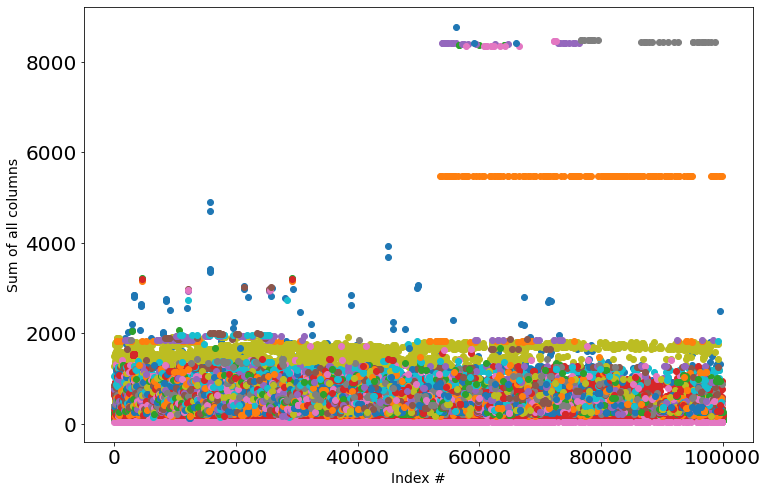

In [ ]:
import pylab as plt

plt.rcParams["font.size"] = 20
plt.rcParams['figure.figsize'] = 12,8

unique_labels = np.unique(db.labels_)
for label in unique_labels:
    x = X_train[y_pred_train == label].sum(axis=1)
    plt.scatter(x.index, x[:], label=label)

plt.xlabel('Index #', fontsize=14)
plt.ylabel('Sum of all columns', fontsize=14)
plt.show()